# Data Preprocessing

## Libraries

We start by importing the necessary libraries and setting some parameters for the whole notebook(such as parameters for plots etc.).We will mainly use:

* Pandas for handling and analysing data
* Seaborn and Matplotlib for data visualization
* Scikit-learn for building ML models

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.set_option('display.max_columns',None)

import matplotlib as mpl
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_style('darkgrid')

mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 15
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12

from scipy import stats
from scipy.stats import norm,skew
from scipy.special import boxcox1p

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score,GridSearchCV,learning_curve
from mlxtend.regressor import StackingCVRegressor

random_state = 42

print('Libraries Loaded!')

Libraries Loaded!


### Getting the Data

The data has already been split into a training set and a test set. We will now load them into pandas dataframes:

In [2]:
train_df = pd.read_csv('C:\Medical cost\med_train.csv')
test_df = pd.read_csv('C:\Medical cost\med_test.csv')

print('DataFrames loaded successfully!')
print('The train set contains {} rows and {} columns'.format(train_df.shape[0],train_df.shape[1]))
print('The test set contains {} rows and {} columns'.format(test_df.shape[0],test_df.shape[1]))


DataFrames loaded successfully!
The train set contains 1070 rows and 7 columns
The test set contains 268 rows and 7 columns


### Target Variable

Skewness: 1.52
Kurtosis: 1.62


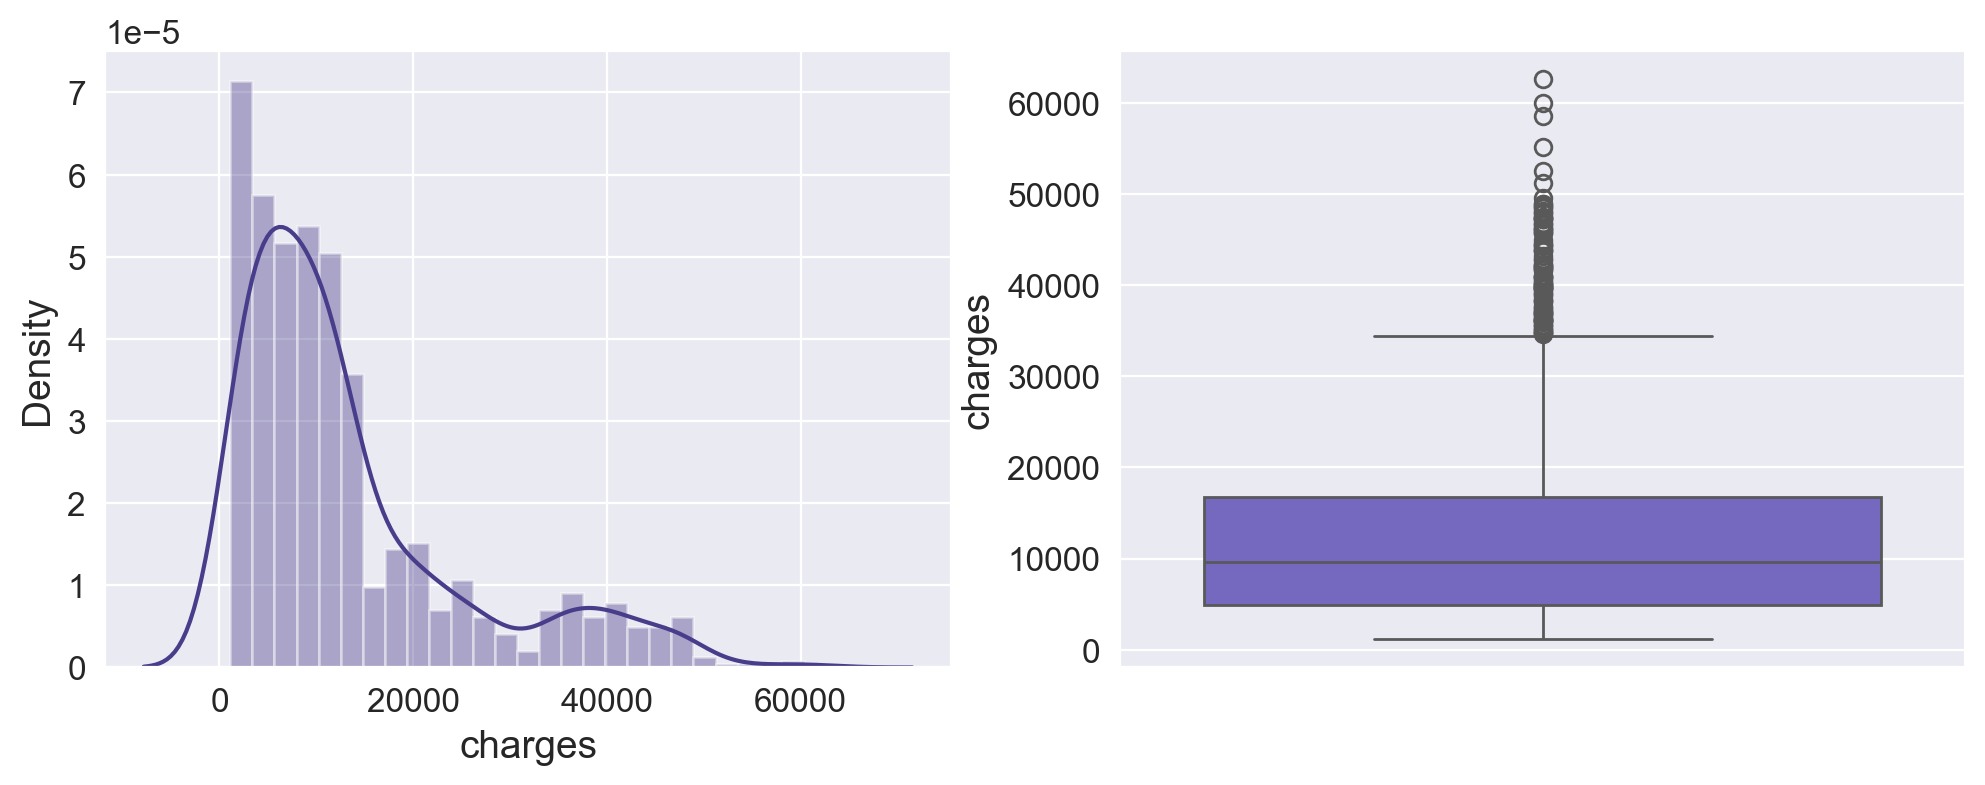

In [3]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

sns.distplot(train_df['charges'],color='darkslateblue',ax=ax1)
sns.boxplot(train_df['charges'],color='slateblue',ax=ax2)

#Skewness and kurtosis
print('Skewness: {}'.format(np.round(train_df['charges'].skew(),2)))
print('Kurtosis: {}'.format(np.round(train_df['charges'].kurt(),2)))

Since the target variable is skewed and we need to treat it before feeding it into the Machine Learning models for effective predictions

Skewness : -0.12
Kurtosis : -0.59


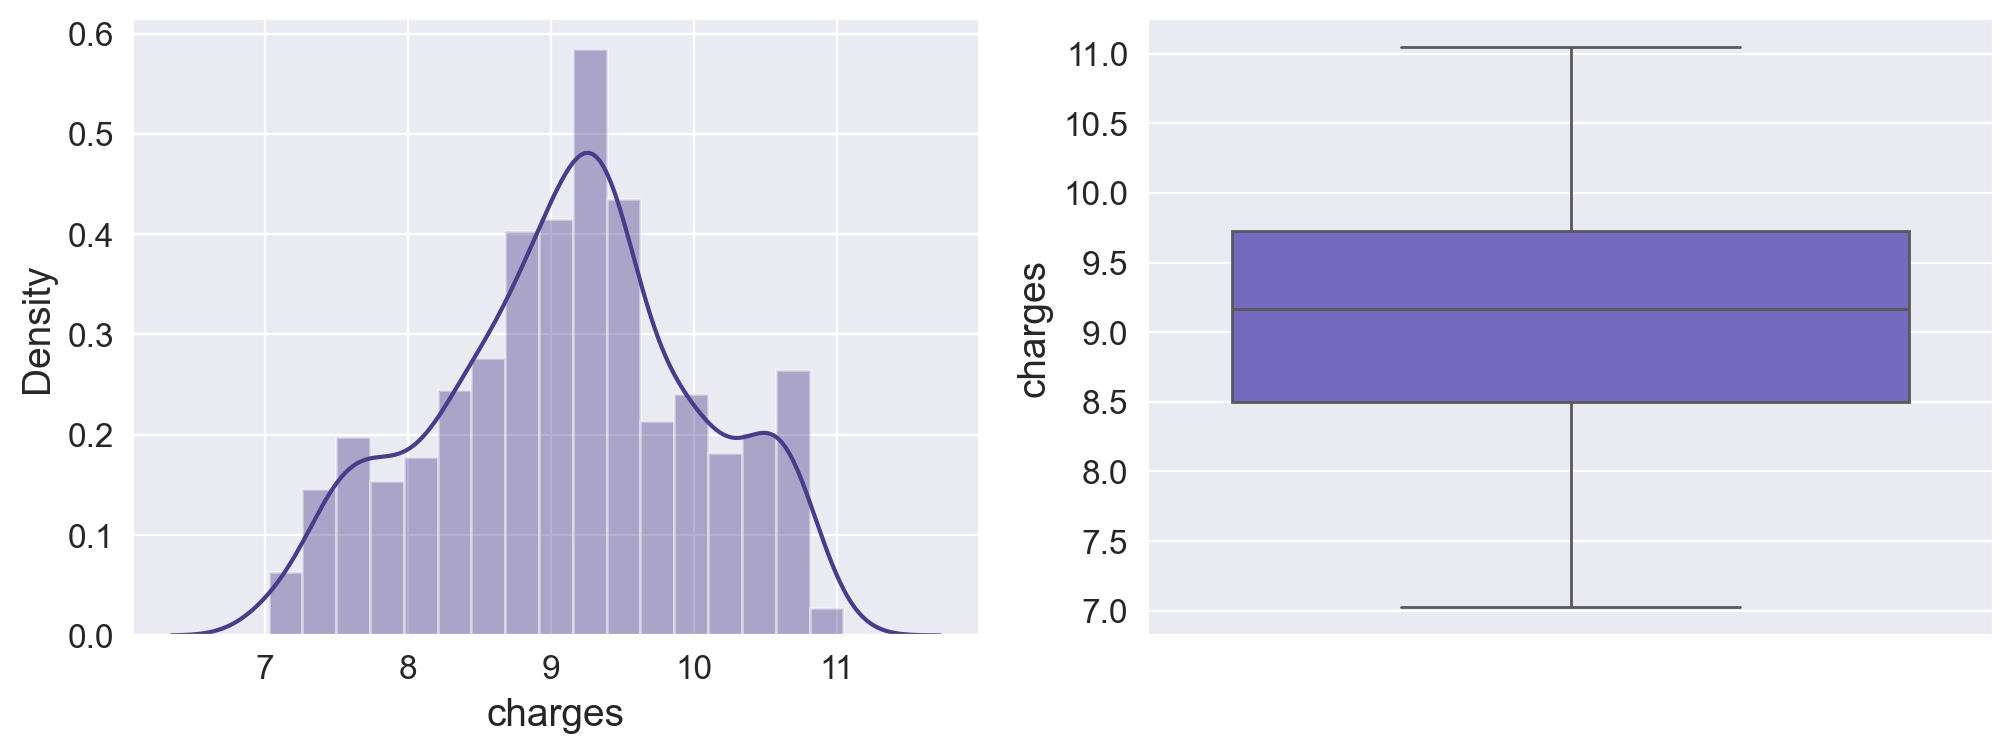

In [4]:
train_df['charges'] = np.log1p(train_df['charges'])

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

sns.distplot(train_df['charges'],color='darkslateblue',ax=ax1)
sns.boxplot(train_df['charges'],color='slateblue',ax=ax2)

#Skewness and kurtosis
print('Skewness : {}'.format(np.round(train_df['charges'].skew(),2)))
print('Kurtosis : {}'.format(np.round(train_df['charges'].kurt(),2)))

We need to perform inverse log transformation before the final prediction

### Outliers

We will now check for outliers in the data and handle them

In [5]:
train_df.head()

,age,sex,bmi,children,smoker,region,charges
0,46,female,19.95,2,no,northwest,9.126398
1,47,female,24.32,0,no,northeast,9.052009
2,52,female,24.86,0,no,southeast,10.207990
3,39,female,34.32,5,no,southeast,9.059265
4,54,female,21.47,3,no,northwest,9.431590


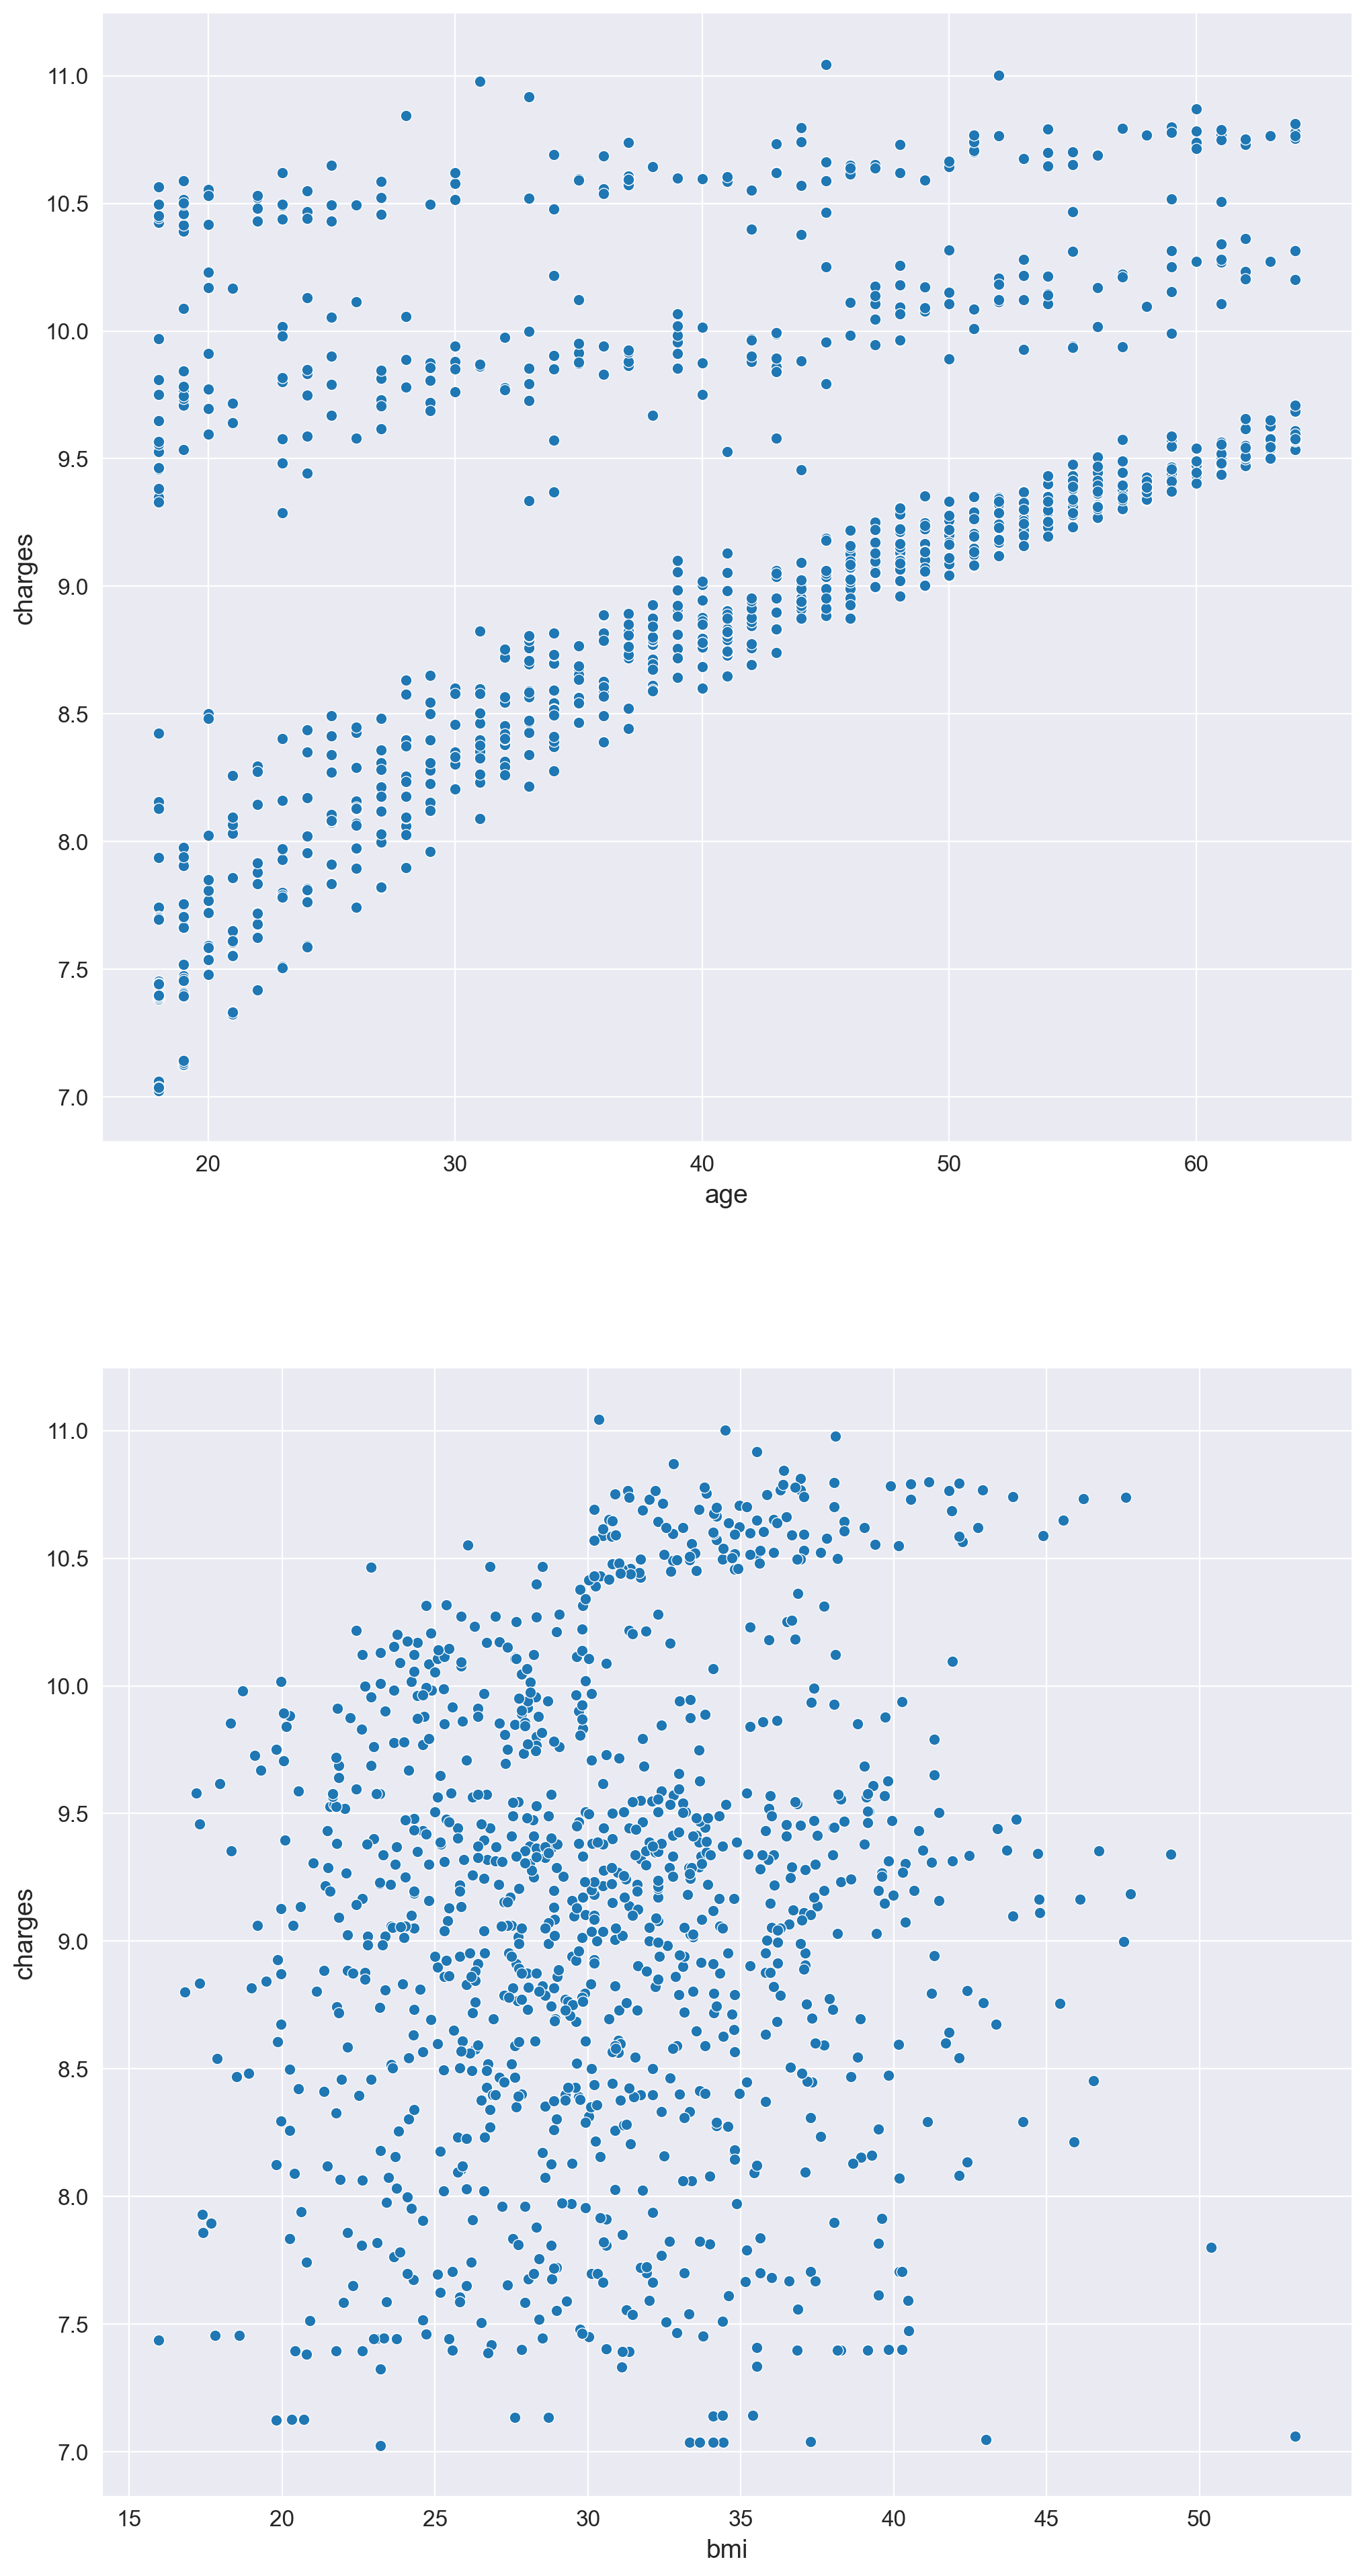

In [6]:
# Lets plot the continuous features and the target variable to spot the outliers
fig = plt.figure(figsize = (12,24))

for index,column in enumerate(['age','bmi']):

    plt.subplot(2,1,index+1)
    sns.scatterplot(x=column,y='charges',data=train_df)

Since there is no proper distinction between data points that are important and data points that are outliers, we will use IQR to replace the outlier values with the median values

In [7]:
# For 'age'
Q1_age = train_df['age'].quantile(0.25)
Q3_age = train_df['age'].quantile(0.75)
IQR_age = Q3_age - Q1_age

train_df['age'] = np.where(
    train_df['age'] > Q3_age + 1.5 * IQR_age, 
    train_df['age'].median(), 
    train_df['age']
)
train_df['age'] = np.where(
    train_df['age'] < Q1_age - 1.5 * IQR_age, 
    train_df['age'].median(), 
    train_df['age']
)

# For 'bmi'
Q1_bmi = train_df['bmi'].quantile(0.25)
Q3_bmi = train_df['bmi'].quantile(0.75)
IQR_bmi = Q3_bmi - Q1_bmi

train_df['bmi'] = np.where(
    train_df['bmi'] > Q3_bmi + 1.5 * IQR_bmi, 
    train_df['bmi'].median(), 
    train_df['bmi']
)
train_df['bmi'] = np.where(
    train_df['bmi'] < Q1_bmi - 1.5 * IQR_bmi, 
    train_df['bmi'].median(), 
    train_df['bmi']
)




In [8]:
train_df.head()

,age,sex,bmi,children,smoker,region,charges
0,46.0,female,19.95,2,no,northwest,9.126398
1,47.0,female,24.32,0,no,northeast,9.052009
2,52.0,female,24.86,0,no,southeast,10.207990
3,39.0,female,34.32,5,no,southeast,9.059265
4,54.0,female,21.47,3,no,northwest,9.431590


### Feature Encoding

In [9]:
from sklearn.preprocessing import OneHotEncoder
#For age and smoker, we will use one hot encoder

#Creating an instance of the encoder
encoder = OneHotEncoder(drop='first',sparse_output=False)
#Specifying the features that need to be encoded
encoder.fit(train_df[['sex','smoker']])
train_df[['sex','smoker']] = encoder.transform(train_df[['sex','smoker']])

#For region, we will perform one hot encoding manually
region_encoded = pd.get_dummies(train_df['region'],drop_first=True)

#dropping region
train_df.drop('region',inplace=True,axis=1)

#Concatenating the dataframes
train_df = pd.concat([train_df,region_encoded],axis=1)






In [10]:
train_df.head()

,age,sex,bmi,children,smoker,charges,northwest,southeast,southwest
0,46.0,0.0,19.95,2,0.0,9.126398,True,False,False
1,47.0,0.0,24.32,0,0.0,9.052009,False,False,False
2,52.0,0.0,24.86,0,0.0,10.207990,False,True,False
3,39.0,0.0,34.32,5,0.0,9.059265,False,True,False
4,54.0,0.0,21.47,3,0.0,9.431590,True,False,False


In [11]:
# Converting the boolean features into integer
train_df['northwest'] = train_df['northwest'].astype(int)
train_df['southeast'] = train_df['southeast'].astype(int)
train_df['southwest'] = train_df['southwest'].astype(int)

In [12]:
train_df.head()

,age,sex,bmi,children,smoker,charges,northwest,southeast,southwest
0,46.0,0.0,19.95,2,0.0,9.126398,1,0,0
1,47.0,0.0,24.32,0,0.0,9.052009,0,0,0
2,52.0,0.0,24.86,0,0.0,10.207990,0,1,0
3,39.0,0.0,34.32,5,0.0,9.059265,0,1,0
4,54.0,0.0,21.47,3,0.0,9.431590,1,0,0


In [13]:
#Scaling the numeric features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

train_df[['age','bmi','children']] = scaler.fit_transform(train_df[['age','bmi','children']])

In [14]:
train_df.head()

,age,sex,bmi,children,smoker,charges,northwest,southeast,southwest
0,0.472227,0.0,-1.788303,0.734336,0.0,9.126398,1,0,0
1,0.543313,0.0,-1.044290,-0.911192,0.0,9.052009,0,0,0
2,0.898745,0.0,-0.952353,-0.911192,0.0,10.207990,0,1,0
3,-0.025379,0.0,0.658256,3.202629,0.0,9.059265,0,1,0
4,1.040918,0.0,-1.529516,1.557100,0.0,9.431590,1,0,0


### Feature Selection

Here, there are a few features to train the Machine Learning model, so we will feed all the features to prevent overfitting.

### Creating the independent and target variable split

In [15]:
X_train = train_df.drop('charges',axis=1)
y_train = train_df['charges']

## Building Machine Learning Models

We are ready to feed the data into the models but before that we need to specify the performance measure. Here we will use **Root Mean Squared Error (RMSE)**, a typical performance measure for regression problems that measures the standard deviation of the errors the system makes in its predictions



## Baseline Models

The aim of this subsection is to calculate the **baseline performance** of 5 different estimators/regressors on the training set. This will enable us to later see how tuning improves each of these models.

The regressors are:

1) Elastic Net
2) Random Forest Regressor
3) Gradient Boosting Regressor
4) XGBRegressor
5) LGBMRegressor

For the baseline models, we will use the default parameters for each regressor and evaluate performance by calculating the metrics using **k-fold cross validation**

Text(0.5, 1.0, 'Cross Validation Scores')

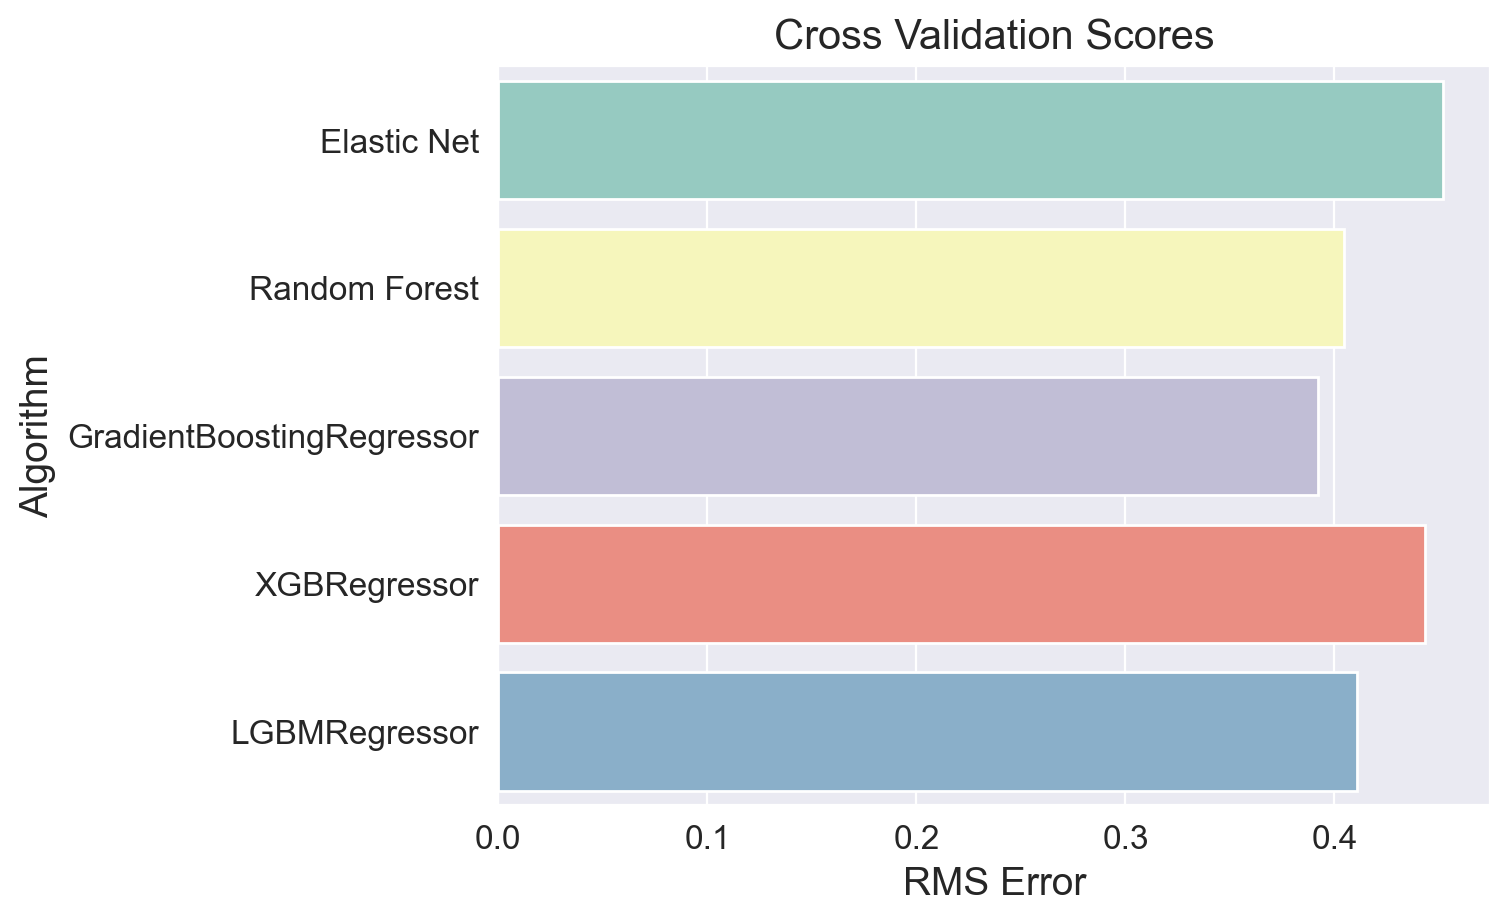

In [16]:
#Creating a list of estimators with their default parameters
est_list = [ElasticNet(alpha=0.01,l1_ratio=0.5,random_state=random_state),
            RandomForestRegressor(random_state=random_state),
            GradientBoostingRegressor(random_state=random_state),
            XGBRegressor(random_state=random_state),
            LGBMRegressor(random_state=random_state)]

#Calculating the cv mean and standard devisation for each one of them

cv_base_mean, cv_std = [],[]
r2_score = []

for est in est_list:

    cv = cross_val_score(est,X_train,y=y_train,scoring='neg_root_mean_squared_error',cv=5,n_jobs=-1)
    cv_base_mean.append(-cv.mean())
    cv_std.append(-cv.std())

#Creating a dataframe and plotting the mean with the error bars

cv_total = pd.DataFrame({'Algorithm' : ['Elastic Net','Random Forest','GradientBoostingRegressor',
                                        'XGBRegressor','LGBMRegressor'],
                                        'CV-Means' : cv_base_mean,
                                        'CV-Errors' : cv_std})

sns.barplot(x='CV-Means',y='Algorithm',data = cv_total,palette = 'Set3',orient='h')
plt.xlabel('RMS Error')
plt.title('Cross Validation Scores')





* All the models perform similarly with the RMS Error around 0.4
* Best performer is Gradient Boosting Regressor

## Model Tuning 

We are ready to tune the hyperparameters using **grid search** and see if the performance improves. 

We will write a simple performance reporting function. The function will :

* Print the best score
* Print the best parameters
* Append each cv score to a list

In [17]:
cv_tuned = []

def Model_Performance(model_name,model):

    print(model_name)
    print('----------------------------')
    print('   Best Score:  ',str(-model.best_score_))#Mean cv score of best estimator
    print('   Best Parameters: ',str(model.best_params_))

    arg_min = np.argmin(model.cv_results_['rank_test_score'])

    scores_list = []
    for i in ['split0_test_score','split1_test_score','split2_test_score','split3_test_score','split4_test_score']:

        scores_list.append(-model.cv_results_[i][arg_min])

    cv_tuned.append({'Model':model_name,
                         'CV Scores' : scores_list})
        
print('Function Ready!')

Function Ready!


### Elastic Net

The first model is Elastic Net, a regularized regression model. In general, we prefer having a bit of regularization in the models(to reduce overfitting), hence why we should avoid plain Linear Regression.

Elastic Net is the middle ground between two other regularized linear regression models: Ridge and Lasso Regression. The difference between each model lies in the regularization term of the cost function.

The parameter alpha controls how much we want to regularize the model, while 'l1_ratio' controls the mix between Ridge and Lasso regularization terms(0 for 100% Ridge and 1 for 100% Lasso)

In [18]:
en = ElasticNet(random_state=random_state)

param_grid = {'alpha' : [0.0001,0.001,0.01,0.1,1],
              'l1_ratio':[0.25,0.5,0.75]}

en_grid = GridSearchCV(en,param_grid=param_grid,cv=5,scoring='neg_root_mean_squared_error',verbose=True,n_jobs=-1)

best_grid_en = en_grid.fit(X_train,y_train)
Model_Performance('Elastic Net',best_grid_en)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Elastic Net
----------------------------
   Best Score:   0.4500645293209168
   Best Parameters:  {'alpha': 0.001, 'l1_ratio': 0.25}


### Random Forest Regressor

To understand Random Forest, we first need to examine Decision Trees. Decision trees are versatile Machine Learning algorithms that make predictions by learning simple decision rules inferred from the features in our data.

A Random Forest, as the name implies, consists of a large number of individual Decision Trees that are trained independently on a random subset of our data. This is a perfect example of Ensemble Learning.

We should note that a Random Forest Regressor has all the hyperparameters of a Decision Tree (to control how trees grow), plus hyperparameters to control the ensemble itself (such as 'n_estimators').

In [19]:
rf = RandomForestRegressor(random_state=random_state)

param_grid = {'n_estimators' : [300],
              'bootstrap' : [True],
              'max_depth' : [10,25,50],
              'max_features' : ['auto','sqrt'],
              'min_samples_leaf' : [1,2,3],
              'min_samples_split':[2,3]}

grid_rf = GridSearchCV(rf,param_grid=param_grid,cv=5,
                       scoring='neg_root_mean_squared_error',verbose=True,n_jobs=-1)
best_grid_rf = grid_rf.fit(X_train,y_train)
Model_Performance('Random Forest Regressor',best_grid_rf)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Random Forest Regressor
----------------------------
   Best Score:   0.3993111022824853
   Best Parameters:  {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 300}


### Gradient Boosting Regressor

Boosting is an Ensemble technique in which predictors are not made independently of each other, but sequentially. The general idea is to train predictors sequentially, each trying to correct its predecessor.

Gradient boosting in particular works by fitting each new predictor to the residual errors made by the previous predictor. You can have a look at page 205 of this book to see how Gradient Boosting can improve an ensemble's prediction.

In [20]:
gbr = GradientBoostingRegressor(random_state=random_state)

param_grid = {'loss':['ls','huber'],
              'n_estimators' : [200],
              'learning_rate' : [0.01,0.1,1],
              'min_samples_split':[3,5,10],
              'max_depth' : [3,5,10]}

grid_gbr = GridSearchCV(gbr,param_grid=param_grid,cv=5,scoring='neg_root_mean_squared_error',
                        verbose=True,n_jobs=-1)

best_grid_gbr = grid_gbr.fit(X_train,y_train)
Model_Performance('GradientBoostingRegressor',best_grid_gbr)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
GradientBoostingRegressor
----------------------------
   Best Score:   0.37882290320783746
   Best Parameters:  {'learning_rate': 0.1, 'loss': 'huber', 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 200}


### XGBRegressor

We can also use XGBRegressor() from the XGBoost library which is 'an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable'.


In [21]:
xgb = XGBRegressor(random_state=random_state)

param_grid = {'learning_rate' : [0.01,0.1,0.5],
              'n_estimators' : [200],
              'max_depth' : [3,6,10],
              'min_child_weight' : [1,5,10],
              'reg_alpha' : [0.01,0.1,1],
              'reg_lambda' : [0.01,0.1,1]}

grid_xgb = GridSearchCV(xgb,param_grid=param_grid,cv=5,
                        scoring='neg_root_mean_squared_error',
                        return_train_score=True,verbose=True,n_jobs=-1)

best_grid_xgb = grid_xgb.fit(X_train,y_train)
Model_Performance('XGBRegressor',best_grid_xgb)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
XGBRegressor
----------------------------
   Best Score:   0.3941150995542815
   Best Parameters:  {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 200, 'reg_alpha': 1, 'reg_lambda': 1}


### LGBMRegressor

LightGBM is another gradient boosting framework (developed by Microsoft) that uses tree based learning algorithms.

In [22]:
lgbm = LGBMRegressor(random_state=random_state)

param_grid = {'max_depth' : [5,10,15],
              'learning_rate' : [0.01,0.1],
              'n_estimators' : [250],
              'feature_fraction' : [0.4,0.6,0.8],
              'min_child_samples':[5,10,20]

}

grid_lgbm = GridSearchCV(lgbm,param_grid=param_grid,cv=5,
                         scoring='neg_root_mean_squared_error',verbose=True,n_jobs=-1)

best_grid_lgbm = grid_lgbm.fit(X_train,y_train)
Model_Performance('LGBMRegressor',best_grid_lgbm)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 1070, number of used features: 8
[LightGBM] [Info] Start training from score 9.113489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

After performing cross-validation on the best set of parameter for each algorithm, we can now compare theis performance before and after tuning:

In [23]:
cv_tuned_mean = [np.round(np.mean(cv_tuned[i]['CV Scores']),4) for i in range(len(cv_tuned))]

cv_total = pd.DataFrame({'Algorithm' : ['Elastic Net','Random Forest',
                                        'Gradient Boosting Regressor','XGBRegressor','LGBMRegressor'],
                                        'Baseline' : cv_base_mean,
                                        'Tuned Performance' : cv_tuned_mean})

cv_total.head()

,Algorithm,Baseline,Tuned Performance
0,Elastic Net,0.452015,0.4501
1,Random Forest,0.404469,0.3993
2,Gradient Boosting Regressor,0.391971,0.3788
3,XGBRegressor,0.443281,0.3941
4,LGBMRegressor,0.410831,0.4034


Tuning indeed improved performance for all models! with Gradient Boosting having the best performance

### Feature Importance

We can visualize feature importance for each of the three last regressors 

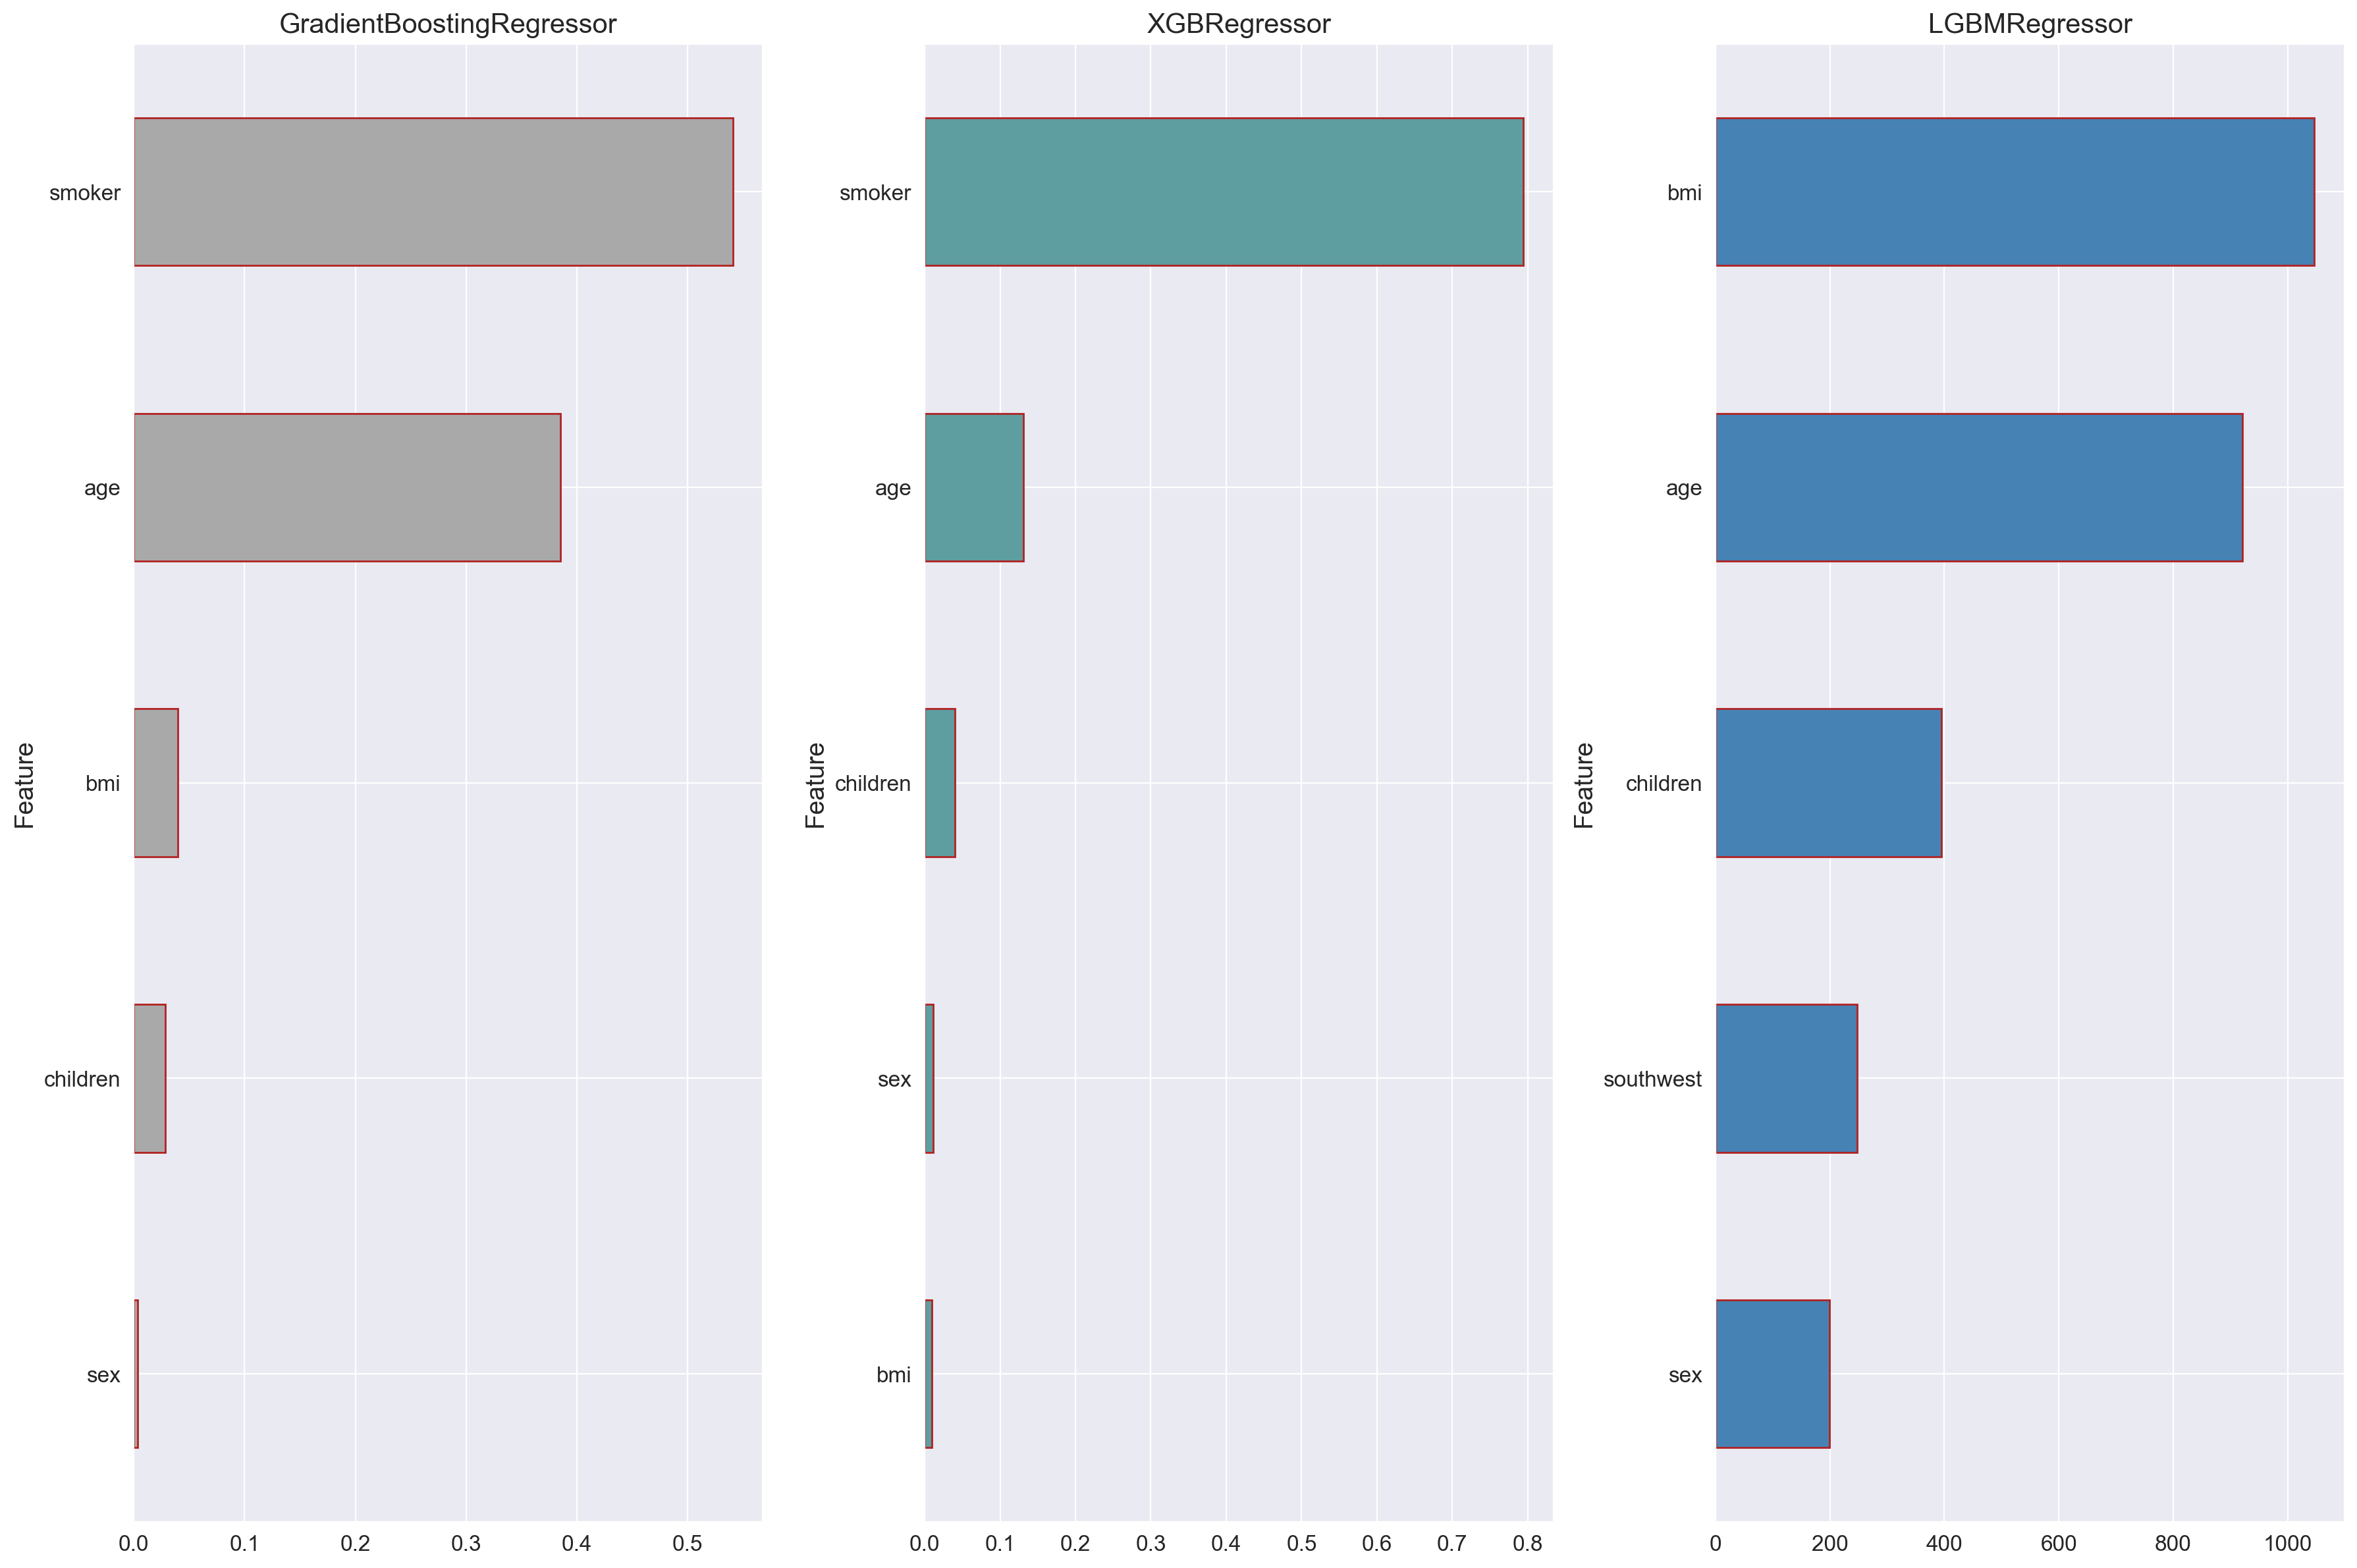

In [24]:
boosting_reg = [{'Name': 'GradientBoostingRegressor', 'Model': best_grid_gbr.best_estimator_, 'Color': 'darkgray'},
                {'Name': 'XGBRegressor', 'Model': best_grid_xgb.best_estimator_, 'Color': 'cadetblue'},
                {'Name': 'LGBMRegressor', 'Model': best_grid_lgbm.best_estimator_, 'Color': 'steelblue'}]


fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (18, 12))

for i in range(len(boosting_reg)):
    importances = pd.DataFrame({'Feature': X_train.columns,
                                'Importance': np.round(boosting_reg[i]['Model'].feature_importances_, 4)})
    importances = importances.sort_values('Importance', ascending = False).set_index('Feature')
    
    most_important = importances.head().iloc[::-1]
    
    ax[i].set_title(boosting_reg[i]['Name'])
    most_important.plot.barh(color = boosting_reg[i]['Color'], edgecolor = 'firebrick', legend = False, ax = ax[i])
      
plt.tight_layout();

Smoker and age are the features that stand out in terms of importance

### Learning Curves

Learning curves are plots of a model’s performance on the training set and the validation set as a function of the training set size. They can help us visualize overfitting/underfitting and the effect of the training size on a model's error.

To generate these curves, simply train the model several times on different sized subsets of the training set:


<Figure size 640x480 with 0 Axes>

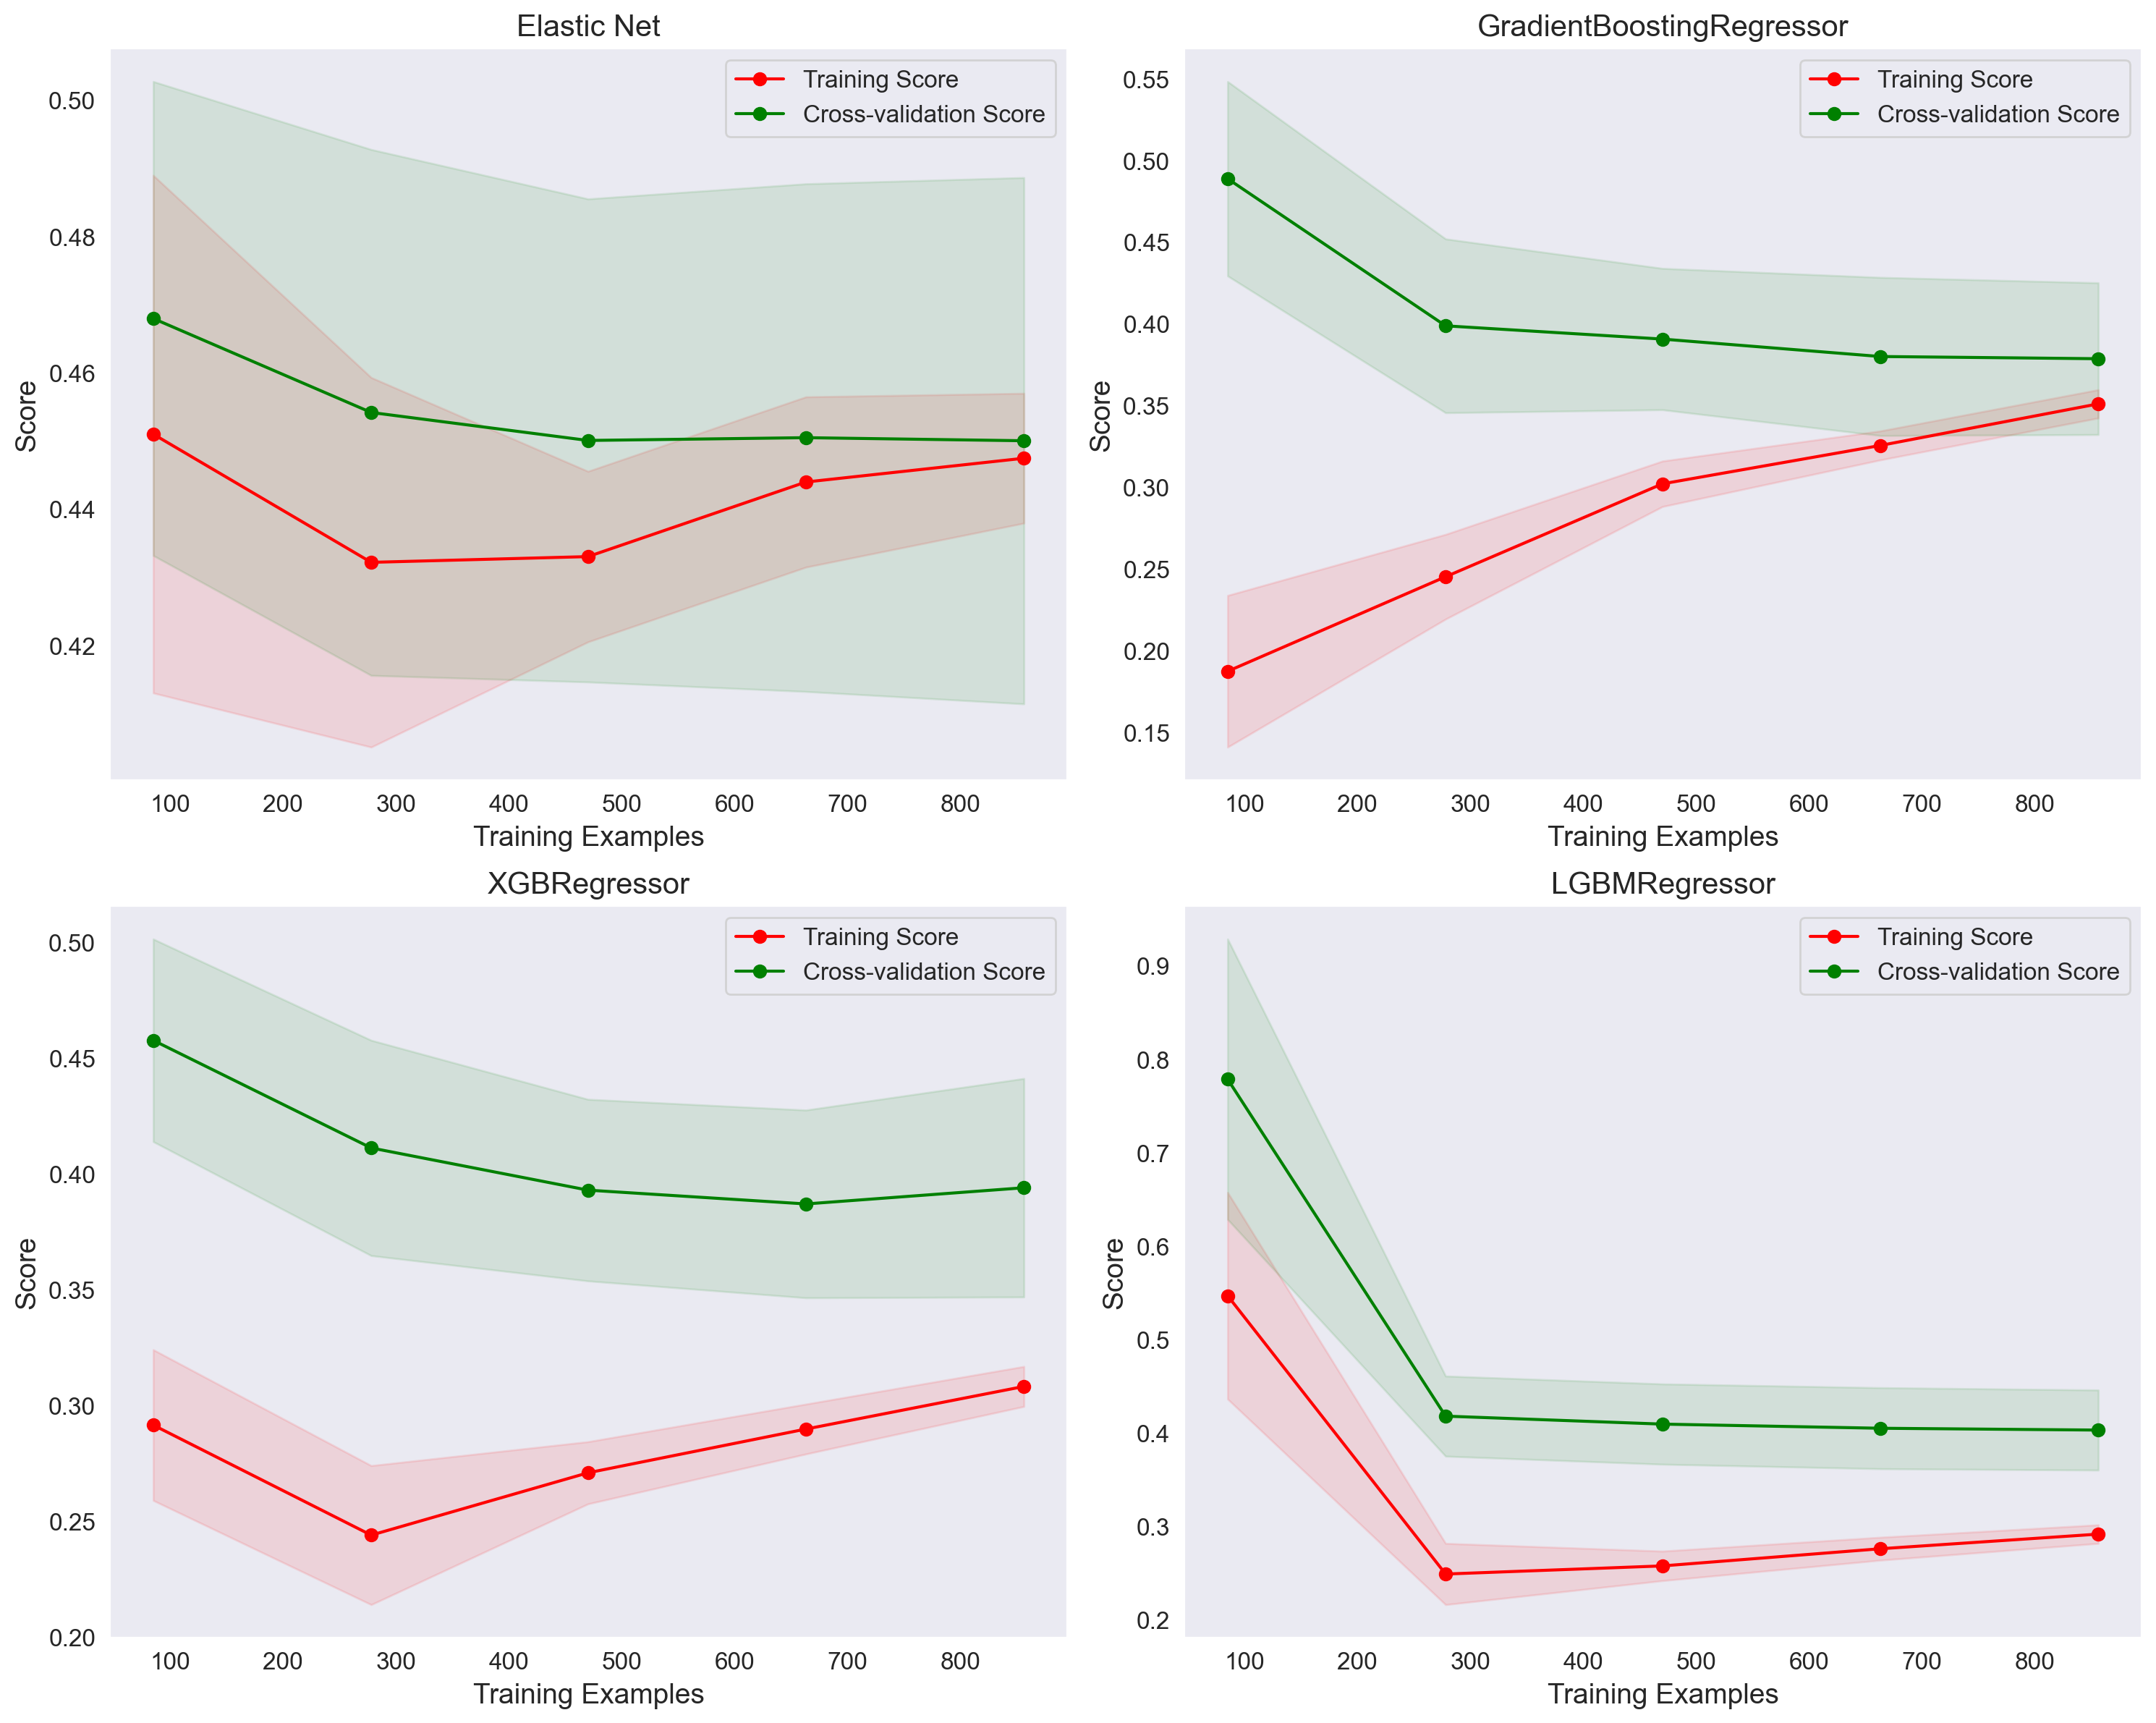

In [25]:
boosting_reg = [{'Name': 'Elastic Net', 'Model': best_grid_en.best_estimator_},
#                 {'Name': 'Random Forest', 'Model': best_grid_rf.best_estimator_},
                {'Name': 'GradientBoostingRegressor', 'Model': best_grid_gbr.best_estimator_},
                {'Name': 'XGBRegressor', 'Model': best_grid_xgb.best_estimator_},
                {'Name': 'LGBMRegressor', 'Model': best_grid_lgbm.best_estimator_,}]

def plot_learning_curve(estimators, X, y, nrows, ncols, cv = None, train_sizes = np.linspace(0.1, 1.0, 5)):

    plt.figure(1)
    fig, axes = plt.subplots(nrows, ncols, figsize = (15, 12))
    
    index = 0
    for row in range(nrows):
        for col in range(ncols):
            if (index == len(boosting_reg)): continue
            
            estimator = estimators[index]
            title = estimators[index]['Name']
            axes[row, col].set_title(title)
            
            axes[row, col].set_xlabel('Training Examples')
            axes[row, col].set_ylabel('Score')
            
            train_sizes, train_scores, test_scores = learning_curve(estimators[index]['Model'], X, y, cv = cv, n_jobs = -1, 
                                                                    train_sizes = train_sizes, scoring = 'neg_mean_squared_error')
    
            train_scores, test_scores = np.sqrt(-train_scores), np.sqrt(-test_scores)
    
            train_scores_mean, train_scores_std = np.mean(train_scores, axis = 1), np.std(train_scores, axis = 1)
            test_scores_mean, test_scores_std = np.mean(test_scores, axis = 1), np.std(test_scores, axis = 1)
            
            axes[row, col].grid()
            axes[row, col].fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
                                     alpha = 0.1, color = 'r')
            axes[row, col].fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
                                     alpha = 0.1, color = 'g')
            axes[row, col].plot(train_sizes, train_scores_mean, 'ro-', label = 'Training Score')
            axes[row, col].plot(train_sizes, test_scores_mean, 'go-', label = 'Cross-validation Score')
            axes[row, col].legend(loc = 'best')
            
            index += 1
            
#     fig.delaxes(axes[1, 2])
            
    plt.tight_layout()
    plt.show()
    
plot_learning_curve(boosting_reg, X_train, y_train, nrows = 2, ncols = 2, cv = 5, train_sizes = np.linspace(0.1, 1.0, 5));

* The error on the training set is always lower compared to the validation set
* If there is a huge gap between the two curves, this indicates overfitting,
**Gradient Boosting Regressor** shows the least gap

### Stacking

Stacking regression is an ensemble learning technique to combine multiple regression models via a meta-regressor. The individual regression models are trained based on the complete training set; then, the meta-regressor is fitted based on the outputs -- meta-features -- of the individual regression models in the ensemble.

In [26]:
stack = StackingCVRegressor(regressors = (best_grid_en.best_estimator_,
#                                           best_grid_rf.best_estimator_,
                                          best_grid_gbr.best_estimator_,
#                                           best_grid_xgb.best_estimator_,
                                          best_grid_lgbm.best_estimator_),
                            meta_regressor = best_grid_xgb.best_estimator_, 
                            use_features_in_secondary = True, random_state = random_state)

stack.fit(X_train, y_train);
stack_score = -cross_val_score(stack, X_train, y_train, scoring = 'neg_root_mean_squared_error', cv = 5)
print('StackingCVRegressor trained and validated!')
print('Mean RMSErrors: {:.4f} ± {:.4f}\n'.format(stack_score.mean(), 
                                                 stack_score.std()))

cv_tuned_mean.append(stack_score.mean())

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 856, number of used features: 8
[LightGBM] [Info] Start training from score 9.104844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

On the training set, we see that Gradient Boosting Regressor performs the best

Let's evaluate the models on the test set

### Test Set Evaluation

Before evaluating the model on the test set, we will perform the necessary preprocessing steps

In [27]:
#For age and smoker, we will use one hot encoder
test_df[['sex','smoker']] = encoder.transform(test_df[['sex','smoker']])

#For region, we will perform one hot encoding manually
region_encoded = pd.get_dummies(test_df['region'],drop_first=True)

#dropping region
test_df.drop('region',inplace=True,axis=1)

#Concatenating the dataframes
test_df = pd.concat([test_df,region_encoded],axis=1)

# Converting the boolean features into integer
test_df['northwest'] = test_df['northwest'].astype(int)
test_df['southeast'] = test_df['southeast'].astype(int)
test_df['southwest'] = test_df['southwest'].astype(int)

test_df[['age','bmi','children']] = scaler.transform(test_df[['age','bmi','children']])

#Performing log transformation on charges
test_df['charges'] = np.log1p(test_df['charges'])

In [28]:
test_df.head()

,age,sex,bmi,children,smoker,charges,northwest,southeast,southwest
0,0.401140,0.0,-0.898722,0.734336,0.0,9.115598,0,0,0
1,-0.238638,0.0,-0.073839,-0.911192,0.0,8.570388,1,0,0
2,1.751782,0.0,-0.607587,-0.911192,1.0,10.286434,1,0,0
3,0.472227,1.0,-0.801677,1.557100,0.0,9.138081,1,0,0
4,-1.447107,1.0,0.249645,-0.911192,1.0,10.426774,1,0,0


In [29]:
#Splitting the independent and dependent variables
X_test = test_df.drop('charges',axis=1)
y_test = test_df['charges']

#### Elastic Net

In [30]:
from sklearn.metrics import r2_score, mean_absolute_error

best_en_model = best_grid_en.best_estimator_

y_pred = best_en_model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)  # RMSE
mae = mean_absolute_error(y_test, y_pred)                 # MAE
r2 = r2_score(y_test, y_pred)                             # R² Score

print("Model Evaluation on Test Set ")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")


Model Evaluation on Test Set 
RMSE: 0.4198
MAE: 0.2727
R² Score: 0.8039


### Random Forest Regressor

In [31]:
best_rf_model = best_grid_rf.best_estimator_

y_pred = best_rf_model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)  # RMSE
mae = mean_absolute_error(y_test, y_pred)                 # MAE
r2 = r2_score(y_test, y_pred)                             # R² Score

print("Model Evaluation on Test Set ")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

Model Evaluation on Test Set 
RMSE: 0.3814
MAE: 0.2341
R² Score: 0.8382


### Gradient Boosting Regressor

In [32]:
best_gbr_model = best_grid_gbr.best_estimator_

y_pred = best_gbr_model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)  # RMSE
mae = mean_absolute_error(y_test, y_pred)                 # MAE
r2 = r2_score(y_test, y_pred)                             # R² Score

print("Model Evaluation on Test Set ")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

Model Evaluation on Test Set 
RMSE: 0.3504
MAE: 0.1231
R² Score: 0.8634


### XGBoost Regressor

In [33]:
best_xgb_model = best_grid_xgb.best_estimator_

y_pred = best_xgb_model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)  # RMSE
mae = mean_absolute_error(y_test, y_pred)                 # MAE
r2 = r2_score(y_test, y_pred)                             # R² Score

print("Model Evaluation on Test Set ")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

Model Evaluation on Test Set 
RMSE: 0.3488
MAE: 0.1902
R² Score: 0.8646


### LGBM Regressor

In [34]:
best_lgbm_model = best_grid_lgbm.best_estimator_

y_pred = best_lgbm_model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)  # RMSE
mae = mean_absolute_error(y_test, y_pred)                 # MAE
r2 = r2_score(y_test, y_pred)                             # R² Score

print("Model Evaluation on Test Set ")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
Model Evaluation on Test Set 
RMSE: 0.3725
MAE: 0.2192
R² Score: 0.8457


### Stacking Regressor


In [35]:
y_pred = stack.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)  # RMSE
mae = mean_absolute_error(y_test, y_pred)                 # MAE
r2 = r2_score(y_test, y_pred)                             # R² Score

print("Model Evaluation on Test Set ")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
Model Evaluation on Test Set 
RMSE: 0.3627
MAE: 0.1932
R² Score: 0.8536


From this we can conclude that  Gradient Boosting Regressor shows an overall great performance on the training and test set, so It will be our final model!

In [38]:
import pickle

with open('med_model.pkl','wb') as file:
    pickle.dump(best_gbr_model,file)
with open('scaler.pkl','wb') as file:
    pickle.dump(scaler,file)
with open('encoder.pkl','wb') as file:
    pickle.dump(encoder,file)